In [1]:
#import all libraries
import heapq
import random
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
#Event and Schedule classes used from class
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [3]:
class Bus_Stop:
    '''
    Creates a queue for customers on a bus stop and handles their service.
    Parameters:
    -----------
    arrival_distribution : scipy object
        Distribution of time interval between arrivals
    stop_number : str
        The number of this stop, given as a string. Numbering starts from 0.
    '''
    def __init__(self, arrival_distribution, stop_number):
        self.arrival_distribution = arrival_distribution
        self.stop_number = stop_number
        self.people_in_queue = 0  # We start with an empty queue
        self.visit_counter = 0 #start at 0 visitors
        self.service_counter = 0 #start with 0 people serviced
        self.arrival_times = [] #store all arrival times from schedule class
        self.departure_times = [] #store all departure times
        self.queue_len = [] #list to store length of queue at each step
    
    def arrival_process(self, schedule):
        '''
        Adds an arrival to the queue
        Parameters
        ----------
        schedule : Schedule
            A Schedule object which has a heap of all events.
        '''
        #increase the queue length
        self.people_in_queue += 1
        self.visit_counter += 1
        self.queue_len.append(self.people_in_queue)
        self.arrival_times.append(schedule.now) #keep track of arrival times

        #add next arrival
        next_arrival = self.arrival_distribution.rvs()
        schedule.add_event_after(next_arrival, self.arrival_process)


class Bus:
    '''
    Keeps track of number of people in the bus and stops visited.
    Parameters:
    -----------
    total_capacity : int
        Maximum capacity of the bus
    travel_time_dist : scipy object
        Distribution of time taken to travel between 2 consecutive stops
    '''

    def __init__(self, total_capacity, travel_time_dist):
        self.occupancy = 0
        self.total_capacity = total_capacity
        self.disembark = {}     #track no. of people disembarking at each stop
        self.travel_time_dist = travel_time_dist
        self.last_stop = ""     #last stop of the bus
        self.occupancies = []   #keep track of ccupancy after each stop

    def embark_time(self, n):
        '''
        Calculate the time for n people to embark on the bus
        Parameters
        ----------
        n : int
            Number of people embarking
        '''
        #distribution of embarking times for n people
        embark_dist = sts.norm(loc = 0.03*n, scale = 0.01*np.sqrt(n))
        t = embark_dist.rvs()   #time to embark
        return t

    def disembark_time(self, n):
        '''
        Calculate the time for n people to disembark from the bus
        Parameters
        ----------
        n : int
            Number of people disembarking
        '''
        #distribution of disembarking times for n people
        disembark_dist = sts.norm(loc = 0.05*n, scale = 0.01*np.sqrt(n))
        t = disembark_dist.rvs()   #time to disembark
        return t

    def bus_arrival(self, schedule, stop, bus_system):
        '''
        Goes through the disembarking process when a bus arrives at a stop
        Parameters
        -----------
        schedule : Schedule
            A Schedule object which has a heap of all events
        stop : Bus_Stop
            A Bus_Stop object for the stop at which bus has arrived
        bus_system : BusSystem
            A BusSystem object that has all the buses and stops
        '''
        #deal with disembarkments first
        stop_n = stop.stop_number
        if stop_n not in self.disembark.keys():
            self.disembark[stop_n] = 0
        
        people_disembarking = self.disembark[stop_n]
        self.occupancy -= people_disembarking
        self.disembark[stop_n] = 0 #reset number of people disembarking
        time_to_disembark = self.disembark_time(people_disembarking)
        schedule.add_event_after(time_to_disembark, self.bus_departure, stop, 
                                 bus_system)

        
    def bus_departure(self, schedule, stop, bus_system):
        '''
        Goes through the embarking process when disembarking is complete
        Parameters
        -----------
        schedule : Schedule
            A Schedule object which has a heap of all events
        stop : Bus_Stop
            A Bus_Stop object for the stop at which bus has arrived
        bus_system : BusSystem
            A BusSystem object that has all the buses and stops
        '''
        #deal with embarkments
        depart_time = schedule.now  #departure time for all new departures
        people_embarking = 0
        while self.occupancy < self.total_capacity and stop.people_in_queue > 0:
            travel_stops = random.randint(1, 7) #number of stops travelled
            #departure stop assuming total 15 stops
            departure_stop = (travel_stops + int(stop.stop_number)) % 15
            dep_key = str(departure_stop)
            if dep_key not in self.disembark.keys():
                self.disembark[dep_key] = 0
            self.disembark[dep_key] += 1
            stop.departure_times.append(depart_time)
            stop.people_in_queue -= 1
            self.occupancy += 1
            people_embarking += 1
        
        self.occupancies.append(self.occupancy)
        time_to_embark = self.embark_time(people_embarking)
        self.last_stop = stop.stop_number
        schedule.add_event_after(time_to_embark, self.traveling, bus_system)
    
    def traveling(self, schedule, bus_system):
        '''
        Adds event for the bus to arrive at the next stop once people embarked
        on the bus.
        Parameters
        ----------
        schedule : Schedule
            A Schedule object which has a heap of all events
        bus_system : BusSystem
            A BusSystem object for which bus has arrived
        '''
        travel_time = self.travel_time_dist.rvs()
        next_stop_number = str((int(self.last_stop) + 1)%15) 
        next_stop = bus_system.stops[next_stop_number]
        schedule.add_event_after(travel_time, self.bus_arrival, next_stop, 
                                 bus_system)


class BusSystem:
    '''
    Create a system for simulation of multiple buses and stops
    Attributes
    ----------
    stops : dict
        Dictionary with all the Bus_Stop objects. The keys are stop number.
    buses : dict
        Dictionary of all Bus objects. The keys are the bus number given as a
        string
    '''
    def __init__(self, stops, buses):
        self.stops = stops
        self.buses = buses
    
    def arrival(self, schedule):
        '''
        Generate first custoer arrivals for each bus stop
        '''
        #go through the arrival process for each arrival event
        for k in self.stops.keys():
            arr_time = self.stops[k].arrival_distribution.rvs()
            schedule.add_event_after(arr_time, self.stops[k].arrival_process)

    def start(self, schedule):
        '''
        Initialize the simulation.
        '''
        #print("Starting the simulation")
        #arrange first customer arrivals at the stops
        self.arrival(schedule)
        
        #arrange bus arrivals after constant time intervals at the first stop
        t = 30/len(self.buses.keys())
        i = 0 #first bus arrives at 5 minutes after the start of the simulation
        for k in self.buses.keys():
            bus = self.buses[k]
            schedule.add_event_after(i, bus.bus_arrival, self.stops["0"],
                                     self)
            i+= t #every successive bus arrives after 5 minutes

def run_simulation(stops, buses, run_until):
    '''
    Run the M/G/n simulation of 15//n buses and 15 stops based on Schedule and
    Event classes. 
    Parameters
    ----------
    stops : dict
        Rate of arrivals of customers
    buses : dict
        Service rate for customers
    '''
    bus_schedule = Schedule()
    bus_system = BusSystem(stops, buses)
    bus_system.start(bus_schedule)
    while bus_schedule.now <= run_until:
        bus_schedule.run_next_event()
    #print("Finished the simulation")
    return bus_system

# Analysis

## Part 1: 3 Buses


I start with 3 buses and see how they perform. Based on the results, I would decrease or increase the number of buses.


But, before beginning the actual analysis, let me first create functions for analysis.

In [4]:
def prep_data_for_analysis(sims):
    wait_times_raw = []       #raw data for all wait times
    max_queues = []           #max queue length for each simulation
    queue_lens_raw = []       #raw data of queue len
    occ_raw = []              #raw data for bus occupencies

    for sim in sims:
        max_queue_sim = []
        for k in sim.stops.keys():
            stop = sim.stops[k]
            people_served = len(stop.departure_times)
            arr_times = stop.arrival_times[:people_served]
            wait_times = np.array(stop.departure_times) - np.array(arr_times)
            wait_times_raw.append(wait_times)
            max_queue_sim.append(max(stop.queue_len))
            queue_lens_raw.append(stop.queue_len)
        max_queues.append(max(max_queue_sim))
        for k in sim.buses.keys():
            occ_raw.append(sim.buses[k].occupancies)
    return wait_times_raw, max_queues, queue_lens_raw, occ_raw

def analyze_wait_times(sims):
    wait_time, max_q, q_len, occ = prep_data_for_analysis(sims)
    flat_wait_times = list(np.concatenate(wait_time).flat)
    #mean and standard deviation of waiting times
    mean_wait = np.mean(flat_wait_times)
    std_wait = np.std(flat_wait_times)
    std_2 = 2*std_wait
    print(f"Average waiting time = {mean_wait}")
    print(f"Standard Deviation = {std_wait}")
    print(f"95% Confidence Interval = [{mean_wait-std_2}, {mean_wait+std_2}]")


    #plot the waiting times for a single bus_stop
    plt.plot(wait_time[1])
    plt.title("Wait times for every arrival over time at a single bus stop")
    plt.xlabel("Arrival number")
    plt.ylabel("Wait time")
    plt.show()

def analyze_q_len(sims):
    wait_time, max_q, q_len, occ = prep_data_for_analysis(sims)
    flat_queue_len = list(np.concatenate(q_len).flat)
    mean_max_q = np.mean(max_q)
    std_2_ql = np.std(max_q)*2
    max_q_l = mean_max_q-std_2_ql        #lower limit of 95% CI
    max_q_h = mean_max_q+std_2_ql        #upper limit of 95% CI
    print(f"Max queue length among all the simulations = {max(max_q)}")
    print(f"Average of maximum queue lengths = {mean_max_q}")
    print(f"95% Confidence Interval for Max Queue Length = [{max_q_l}, {max_q_h}]")

    #plot the queue lengths over time for a single bus_stop
    plt.plot(q_len[1])
    plt.title("Queue length over time for a single bus stop")
    plt.xlabel("Arrival number")
    plt.ylabel("Queue length")
    plt.show()

def analyze_bus_occupancy(sims):
    wait_time, max_q, q_len, occ = prep_data_for_analysis(sims)
    flat_occ = list(np.concatenate(occ).flat)
    avg_occ = np.mean(flat_occ)     #mean of bus occupency
    occ_std = np.std(flat_occ)      #standard deviation of bus occupency
    occ_l = avg_occ - 2*occ_std     #lower limit of 95% CI
    occ_h = avg_occ + 2*occ_std     #upper limit of 95% CI

    print(f"Average bus occupancy = {avg_occ}")
    print(f"95% Confidence Interval for bus occupancy = [{occ_l}, {occ_h}]")

    #plot bus occupancy vs stops for a single bus example
    plt.plot(occ[1])
    plt.title("Bus Occupancy after every bus stop for a single bus")
    plt.xlabel("Total Stops made")
    plt.ylabel("Bus Occupancy")
    plt.show()

In [5]:
#customer arrival distribution
arrival_rate = 1
arrival_dist = sts.expon(scale = 1/arrival_rate)

#bus travel distribution
travel_time_dist = sts.norm(loc = 2, scale = 0.5)
bus_capacity = 130

#minutes in a day
t_sim = 1440

#store all the simulations
sims_3 = []

#run the simulation 100 times
for i in range(100):
    #create the dictionary for stops
    stops = {
        "0":Bus_Stop(arrival_dist, "0"),
        "1":Bus_Stop(arrival_dist, "1"),
        "2":Bus_Stop(arrival_dist, "2"),
        "3":Bus_Stop(arrival_dist, "3"),
        "4":Bus_Stop(arrival_dist, "4"),
        "5":Bus_Stop(arrival_dist, "5"),
        "6":Bus_Stop(arrival_dist, "6"),
        "7":Bus_Stop(arrival_dist, "7"),
        "8":Bus_Stop(arrival_dist, "8"),
        "9":Bus_Stop(arrival_dist, "9"),
        "10":Bus_Stop(arrival_dist, "10"),
        "11":Bus_Stop(arrival_dist, "11"),
        "12":Bus_Stop(arrival_dist, "12"),
        "13":Bus_Stop(arrival_dist, "13"),
        "14":Bus_Stop(arrival_dist, "14")
    }

    #first, start with 3 buses
    buses = {
        "bus_1":Bus(bus_capacity, travel_time_dist),
        "bus_2":Bus(bus_capacity, travel_time_dist),
        "bus_3":Bus(bus_capacity, travel_time_dist)
    }

    sims_3.append(run_simulation(stops, buses, run_until = t_sim))
    if i%10 == 0:
        print(f"Finished {i} simulations")

Finished 0 simulations
Finished 10 simulations
Finished 20 simulations
Finished 30 simulations
Finished 40 simulations
Finished 50 simulations
Finished 60 simulations
Finished 70 simulations
Finished 80 simulations
Finished 90 simulations


Average waiting time = 22.54165439421259
Standard Deviation = 14.344899485601255
95% Confidence Interval = [-6.148144576989921, 51.2314533654151]


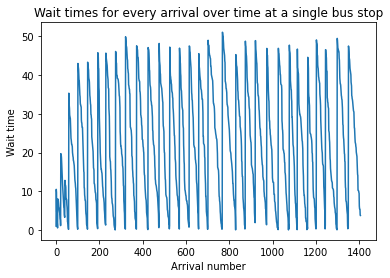

In [6]:
#first, let us analyze the waiting times
analyze_wait_times(sims_3)

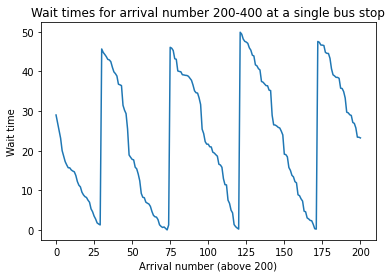

In [21]:
#let us look at the periodic pattern in a bit more detail
wait_time, max_q, q_len, occ = prep_data_for_analysis(sims_3) 

#plot the waiting times for a single bus_stop between 200-400 arrivals
plt.plot(wait_time[1][200:401])
plt.title("Wait times for arrival number 200-400 at a single bus stop")
plt.xlabel("Arrival number (above 200)")
plt.ylabel("Wait time")
plt.show()

Max queue length among all the simulations = 79
Average of maximum queue lengths = 70.32
95% Confidence Interval for Max Queue Length = [64.40135150562224, 76.23864849437774]


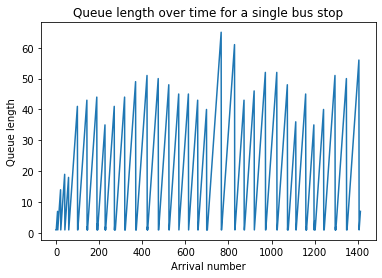

In [7]:
#Now, let us look at the queue lengths at all the stops
analyze_q_len(sims_3)

Average bus occupancy = 65.09828429111705
95% Confidence Interval for bus occupancy = [10.200816365367821, 119.9957522168663]


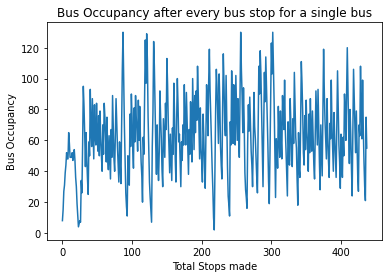

In [8]:
#Finally, let us look at the bus occupancy
analyze_bus_occupancy(sims_3)

## Part 2: 4 buses

In [9]:
#store all the simulations
sims_4 = []

#run the simulation 100 times
for i in range(100):
    #create the dictionary for stops
    stops = {
        "0":Bus_Stop(arrival_dist, "0"),
        "1":Bus_Stop(arrival_dist, "1"),
        "2":Bus_Stop(arrival_dist, "2"),
        "3":Bus_Stop(arrival_dist, "3"),
        "4":Bus_Stop(arrival_dist, "4"),
        "5":Bus_Stop(arrival_dist, "5"),
        "6":Bus_Stop(arrival_dist, "6"),
        "7":Bus_Stop(arrival_dist, "7"),
        "8":Bus_Stop(arrival_dist, "8"),
        "9":Bus_Stop(arrival_dist, "9"),
        "10":Bus_Stop(arrival_dist, "10"),
        "11":Bus_Stop(arrival_dist, "11"),
        "12":Bus_Stop(arrival_dist, "12"),
        "13":Bus_Stop(arrival_dist, "13"),
        "14":Bus_Stop(arrival_dist, "14")
    }

    #try 4 buses
    buses = {
        "bus_1":Bus(bus_capacity, travel_time_dist),
        "bus_2":Bus(bus_capacity, travel_time_dist),
        "bus_3":Bus(bus_capacity, travel_time_dist),
        "bus_4":Bus(bus_capacity, travel_time_dist)
    }

    sims_4.append(run_simulation(stops, buses, run_until = t_sim))
    if i%10 == 0:
        print(f"Finished {i} simulations")

Finished 0 simulations
Finished 10 simulations
Finished 20 simulations
Finished 30 simulations
Finished 40 simulations
Finished 50 simulations
Finished 60 simulations
Finished 70 simulations
Finished 80 simulations
Finished 90 simulations


Average waiting time = 18.658124098207594
Standard Deviation = 12.238498276734546
95% Confidence Interval = [-5.8188724552614985, 43.13512065167669]


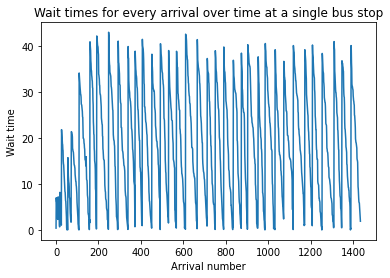

In [10]:
#analyze waiting times first
analyze_wait_times(sims_4)

Max queue length among all the simulations = 70
Average of maximum queue lengths = 61.76
95% Confidence Interval for Max Queue Length = [56.267313953992996, 67.252686046007]


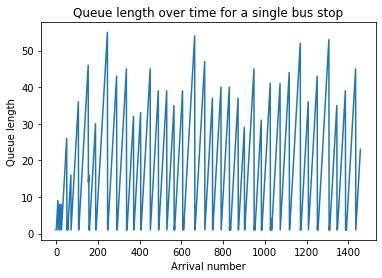

In [11]:
#analyze queue length
analyze_q_len(sims_4)

Average bus occupancy = 42.17594383480591
95% Confidence Interval for bus occupancy = [-6.396251493877436, 90.74813916348927]


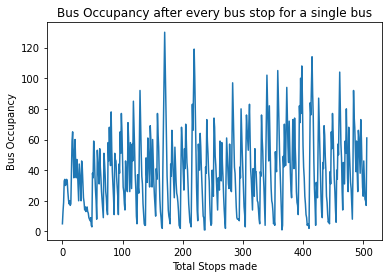

In [12]:
#analyze bus occupancy
analyze_bus_occupancy(sims_4)

## Part 3: 5 buses

In [13]:
#store all the simulations
sims_5 = []

#run the simulation 100 times
for i in range(100):
    #create the dictionary for stops
    stops = {
        "0":Bus_Stop(arrival_dist, "0"),
        "1":Bus_Stop(arrival_dist, "1"),
        "2":Bus_Stop(arrival_dist, "2"),
        "3":Bus_Stop(arrival_dist, "3"),
        "4":Bus_Stop(arrival_dist, "4"),
        "5":Bus_Stop(arrival_dist, "5"),
        "6":Bus_Stop(arrival_dist, "6"),
        "7":Bus_Stop(arrival_dist, "7"),
        "8":Bus_Stop(arrival_dist, "8"),
        "9":Bus_Stop(arrival_dist, "9"),
        "10":Bus_Stop(arrival_dist, "10"),
        "11":Bus_Stop(arrival_dist, "11"),
        "12":Bus_Stop(arrival_dist, "12"),
        "13":Bus_Stop(arrival_dist, "13"),
        "14":Bus_Stop(arrival_dist, "14")
    }

    #try 5 buses
    buses = {
        "bus_1":Bus(bus_capacity, travel_time_dist),
        "bus_2":Bus(bus_capacity, travel_time_dist),
        "bus_3":Bus(bus_capacity, travel_time_dist),
        "bus_4":Bus(bus_capacity, travel_time_dist),
        "bus_5":Bus(bus_capacity, travel_time_dist)
    }

    sims_5.append(run_simulation(stops, buses, run_until = t_sim))
    if i%10 == 0:
        print(f"Finished {i} simulations")

Finished 0 simulations
Finished 10 simulations
Finished 20 simulations
Finished 30 simulations
Finished 40 simulations
Finished 50 simulations
Finished 60 simulations
Finished 70 simulations
Finished 80 simulations
Finished 90 simulations


Average waiting time = 16.544982517480747
Standard Deviation = 11.202877533710215
95% Confidence Interval = [-5.860772549939682, 38.95073758490118]


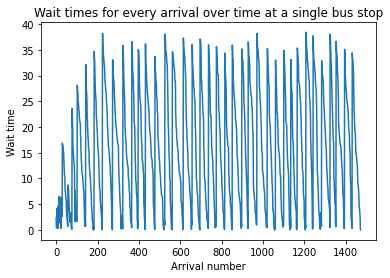

In [14]:
analyze_wait_times(sims_5)

Max queue length among all the simulations = 66
Average of maximum queue lengths = 57.59
95% Confidence Interval for Max Queue Length = [51.676659150700004, 63.5033408493]


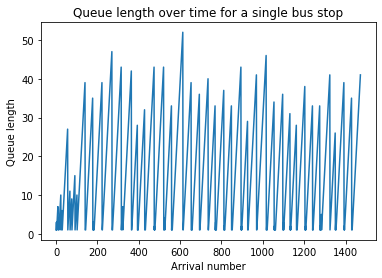

In [15]:
analyze_q_len(sims_5)

Average bus occupancy = 31.198081976599088
95% Confidence Interval for bus occupancy = [-12.264607007509259, 74.66077096070744]


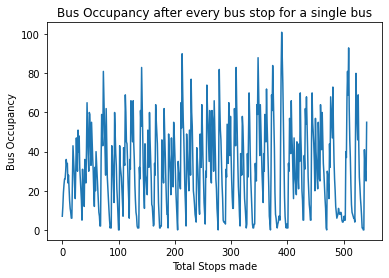

In [16]:
analyze_bus_occupancy(sims_5)

## Part 4: 6 buses

In [17]:
#store all the simulations
sims_6 = []

#run the simulation 100 times
for i in range(100):
    #create the dictionary for stops
    stops = {
        "0":Bus_Stop(arrival_dist, "0"),
        "1":Bus_Stop(arrival_dist, "1"),
        "2":Bus_Stop(arrival_dist, "2"),
        "3":Bus_Stop(arrival_dist, "3"),
        "4":Bus_Stop(arrival_dist, "4"),
        "5":Bus_Stop(arrival_dist, "5"),
        "6":Bus_Stop(arrival_dist, "6"),
        "7":Bus_Stop(arrival_dist, "7"),
        "8":Bus_Stop(arrival_dist, "8"),
        "9":Bus_Stop(arrival_dist, "9"),
        "10":Bus_Stop(arrival_dist, "10"),
        "11":Bus_Stop(arrival_dist, "11"),
        "12":Bus_Stop(arrival_dist, "12"),
        "13":Bus_Stop(arrival_dist, "13"),
        "14":Bus_Stop(arrival_dist, "14")
    }

    #try 6 buses
    buses = {
        "bus_1":Bus(bus_capacity, travel_time_dist),
        "bus_2":Bus(bus_capacity, travel_time_dist),
        "bus_3":Bus(bus_capacity, travel_time_dist),
        "bus_4":Bus(bus_capacity, travel_time_dist),
        "bus_5":Bus(bus_capacity, travel_time_dist),
        "bus_6":Bus(bus_capacity, travel_time_dist)
    }

    sims_6.append(run_simulation(stops, buses, run_until = t_sim))
    if i%10 == 0:
        print(f"Finished {i} simulations")

Finished 0 simulations
Finished 10 simulations
Finished 20 simulations
Finished 30 simulations
Finished 40 simulations
Finished 50 simulations
Finished 60 simulations
Finished 70 simulations
Finished 80 simulations
Finished 90 simulations


Average waiting time = 15.170520662265108
Standard Deviation = 10.571388572018584
95% Confidence Interval = [-5.97225648177206, 36.31329780630227]


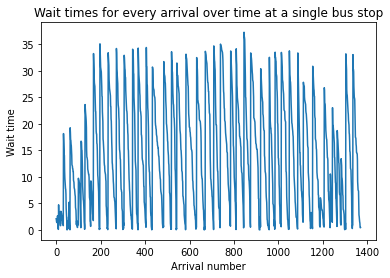

In [18]:
analyze_wait_times(sims_6)

Max queue length among all the simulations = 61
Average of maximum queue lengths = 54.74
95% Confidence Interval for Max Queue Length = [49.597082540036254, 59.88291745996375]


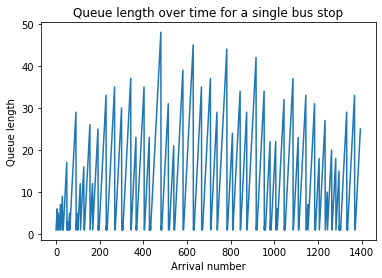

In [19]:
analyze_q_len(sims_6)

Average bus occupancy = 24.783151821090353
95% Confidence Interval for bus occupancy = [-14.834771317366144, 64.40107495954685]


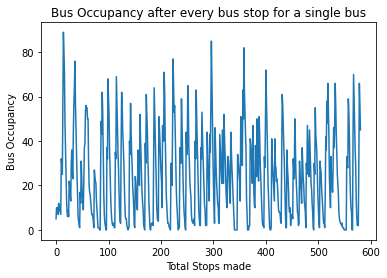

In [20]:
analyze_bus_occupancy(sims_6)